<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/Surface-Water-Mapping-Modis/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
! pip install xee -q

In [5]:
import ee
import geemap
import xarray as xr
import xee
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter

In [6]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')

In [35]:
map=geemap.Map(basemap="SATELLITE")
mapmap=geemap.Map(basemap="SATELLITE")
map

In [34]:
start_time = '2024-01-01'
end_time = '2024-12-31'
roi = map.draw_last_feature.geometry()

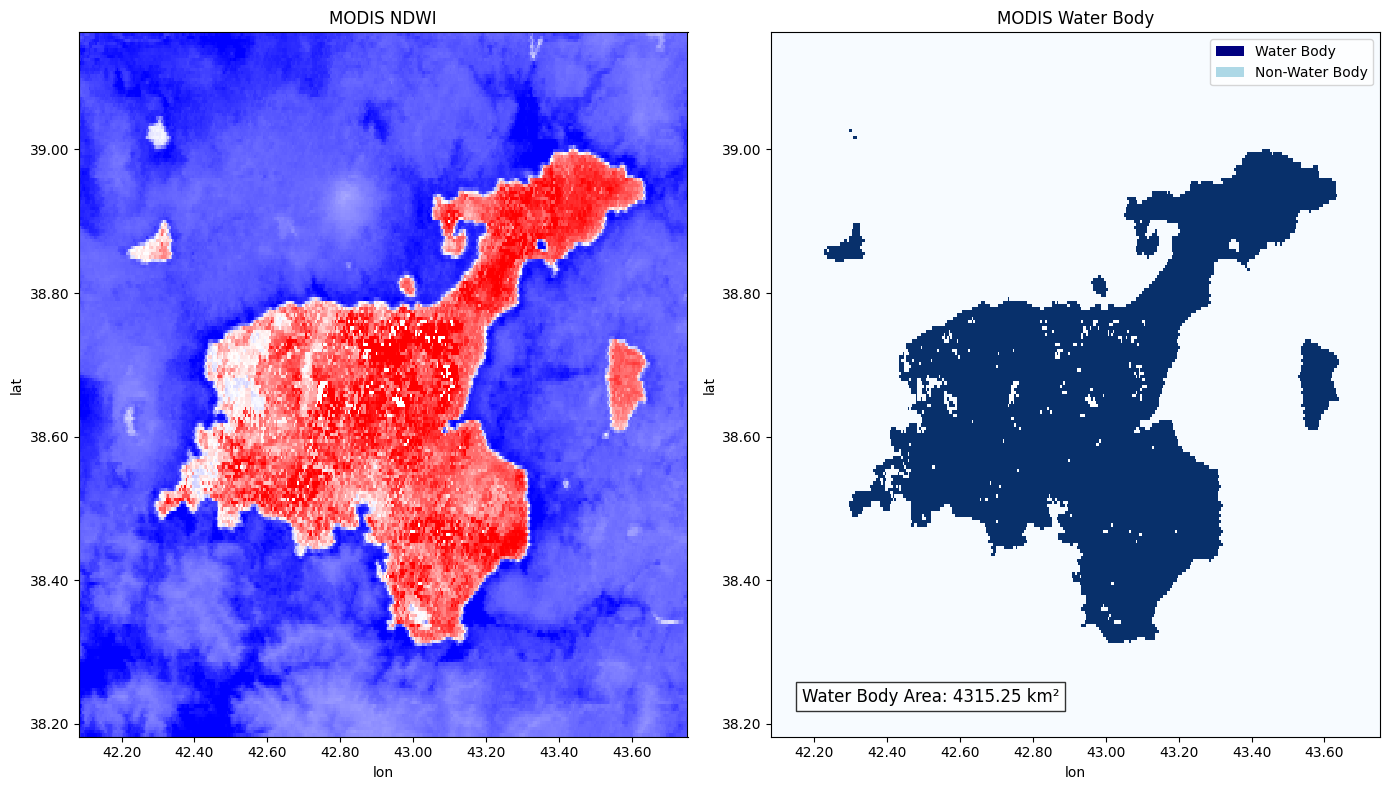

In [35]:
###############################
# Modis NDWI + Clustering #
###############################

# Load MODIS collection and filter
Modis = (
    ee.ImageCollection("MODIS/061/MOD09A1")
    .select(['sur_refl_b02', 'sur_refl_b04'])
    .filterDate(start_time, end_time)
    .filterBounds(roi)
)

def add_year(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    return img.set('year', year)

Modis_with_year = Modis.map(add_year)
years = Modis_with_year.aggregate_array('year').distinct().sort()

def yearly_mean(year):
    year = ee.Number(year)
    filtered = Modis_with_year.filter(ee.Filter.eq('year', year))
    mean_image = filtered.mean().set('year', year)
    return mean_image

yearly_means = ee.ImageCollection(years.map(yearly_mean))

def ndwi(img):
    return img.normalizedDifference(['sur_refl_b04', 'sur_refl_b02']).rename('ndwi').copyProperties(img, img.propertyNames())

ndwi_yearly = yearly_means.map(ndwi)

years_list = ndwi_yearly.aggregate_array('year').getInfo()

# Open dataset as xarray
ds = xr.open_dataset(
    ndwi_yearly,
    engine='ee',
    crs='EPSG:4326',
    scale=0.0045,
    geometry=roi
)

ds['time'] = pd.to_datetime([str(y) for y in years_list]).year
ndwi_annual = ds['ndwi']

# Prepare dataframe for clustering (last year)
df = ds.sel(time=years_list[-1]).to_dataframe().reset_index()
df = df.dropna(subset=['ndwi'])

# Calculate automatic NDWI min and max for plotting
ndwi_min_modis = np.percentile(df['ndwi'], 2)
ndwi_max_modis = np.percentile(df['ndwi'], 98)

model = KMeans(n_clusters=2, random_state=42)
df['clustering_raw'] = model.fit_predict(df[['ndwi']])

cluster_means = df.groupby('clustering_raw')['ndwi'].mean()
water_label = cluster_means.idxmax()
df['clustering'] = (df['clustering_raw'] == water_label).astype(int)

xarr = df.set_index(['lat', 'lon']).to_xarray()
xarr = xarr.sortby('lon').sortby('lat')

lake_pixels = (xarr.clustering == 1).sum().values.item()
lake_area = lake_pixels * 0.25  # km² per pixel (adjust if needed)



import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(1, 2, figsize=(14, 8))  # 1 row, 2 columns

# 1. MODIS NDWI (Last Year) — without colorbar
ndwi_annual.isel(time=-1).plot(
    ax=axes[0],
    x='lon',
    y='lat',
    cmap='bwr',
    vmin=ndwi_min_modis,
    vmax=ndwi_max_modis,
    add_colorbar=False  # <-- removed colorbar
)
axes[0].set_title("MODIS NDWI")
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# 2. MODIS Clustering (Water Mask)
xarr.clustering.plot(
    ax=axes[1],
    x='lon',
    y='lat',
    cmap='Blues',
    vmin=0,
    vmax=1,
    add_colorbar=False
)
axes[1].set_title("MODIS Water Body")
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Water body area text annotation
axes[1].text(
    0.05, 0.05,
    f"Water Body Area: {lake_area:.2f} km²",
    transform=axes[1].transAxes,
    fontsize=12,
    color='black',
    bbox=dict(facecolor='white', alpha=0.8)
)

# Custom legend for water vs non-water
legend_elements = [
    Patch(facecolor='navy', label='Water Body'),
    Patch(facecolor='lightblue', label='Non-Water Body')
]
axes[1].legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()
